In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = trp
band = 1
commitnumber = d5931a1
conc = None
dv = 0.02
klin = 0
molecule = h2o
ng_adju = [0, 0, 0]
ng_refs = [3, 3, 6]
nv = 50
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(1, 250), (30, 250), (300, 250)]
tsfc = 300
vmax = 340
vmin = 20
w_diffuse = [(1.66, 1.66, 1.66), (1.66, 1.66, 1.66), (1.66, 1.66, 1.5, 1.5, 1.5, 1.5)]
wgt = [(0.2, 0.2, 0.2), (0.2, 0.2, 0.2), (0.2, 0.2, 0.65, 0.65, 0.65, 0.65)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

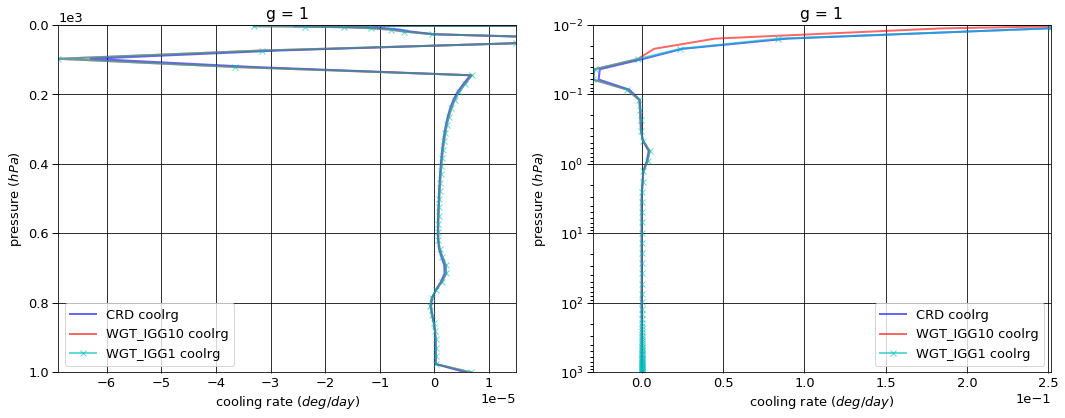

# Figure: cooling rate g-group 2

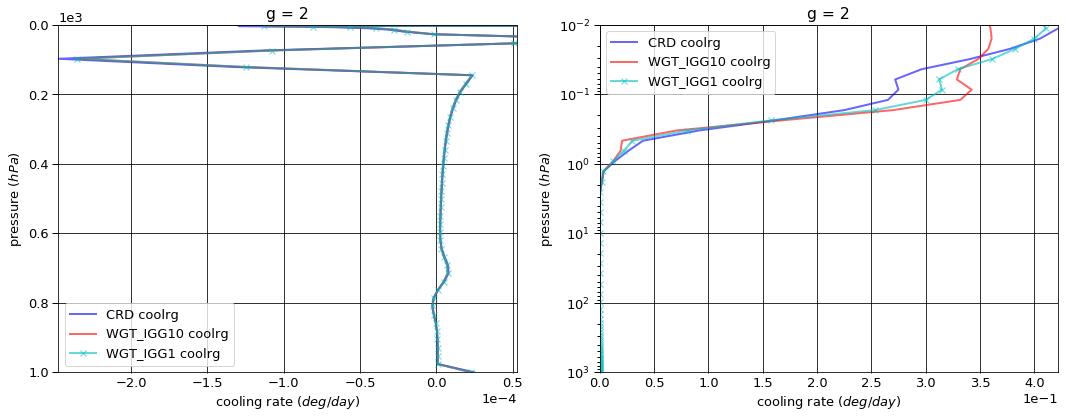

# Figure: cooling rate g-group 3

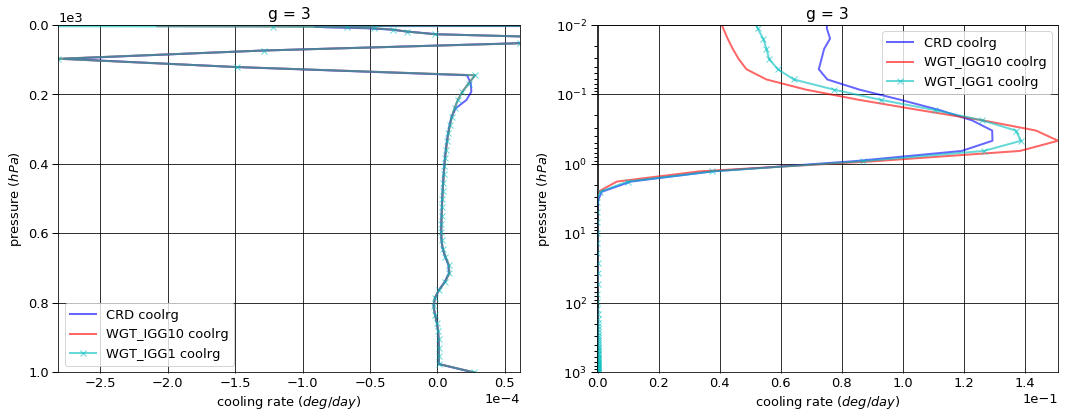

# Figure: cooling rate g-group 4

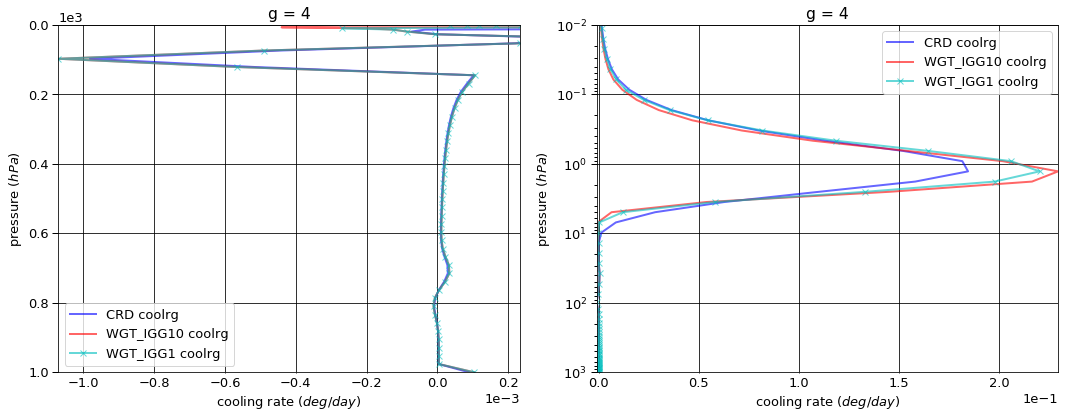

# Figure: cooling rate g-group 5

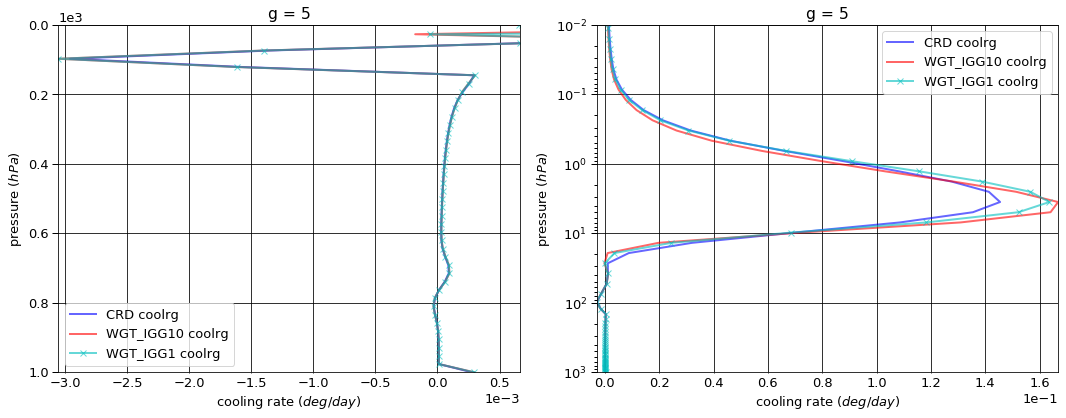

# Figure: cooling rate g-group 6

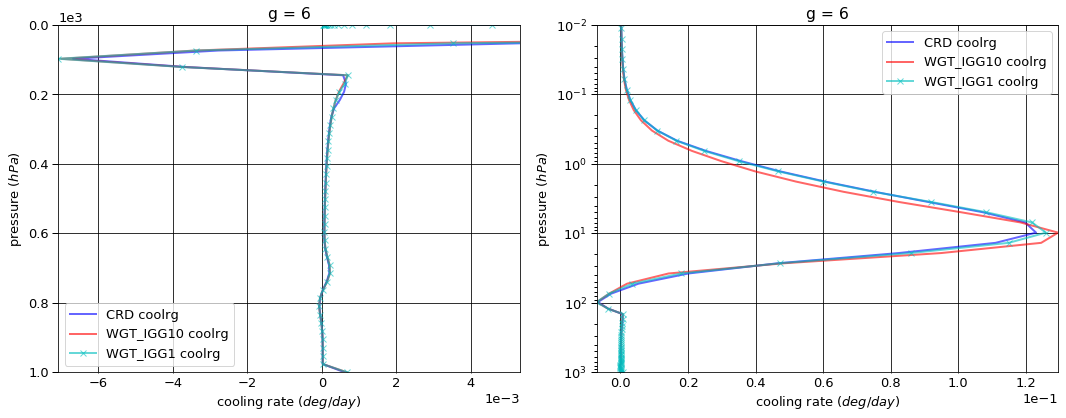

# Figure: cooling rate g-group 7

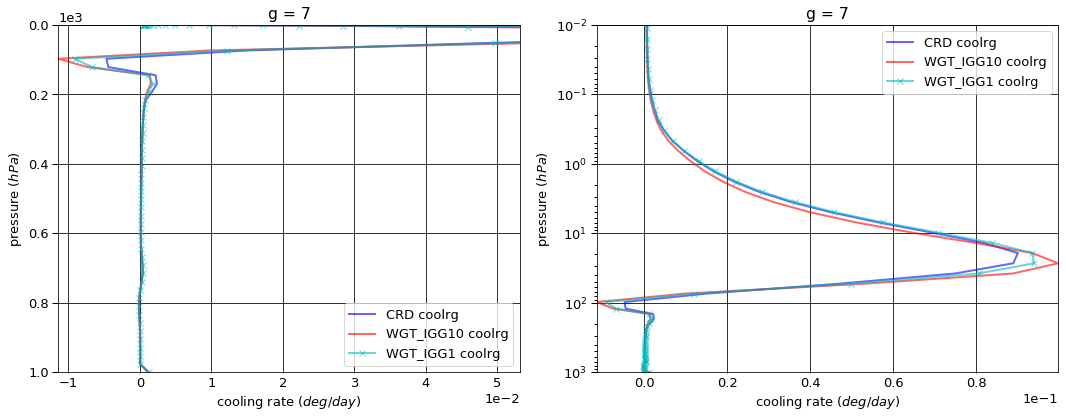

# Figure: cooling rate g-group 8

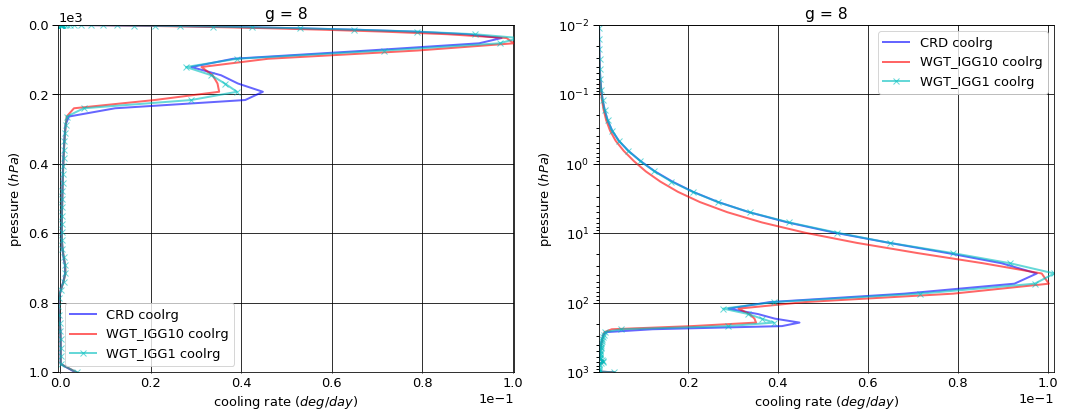

# Figure: cooling rate g-group 9

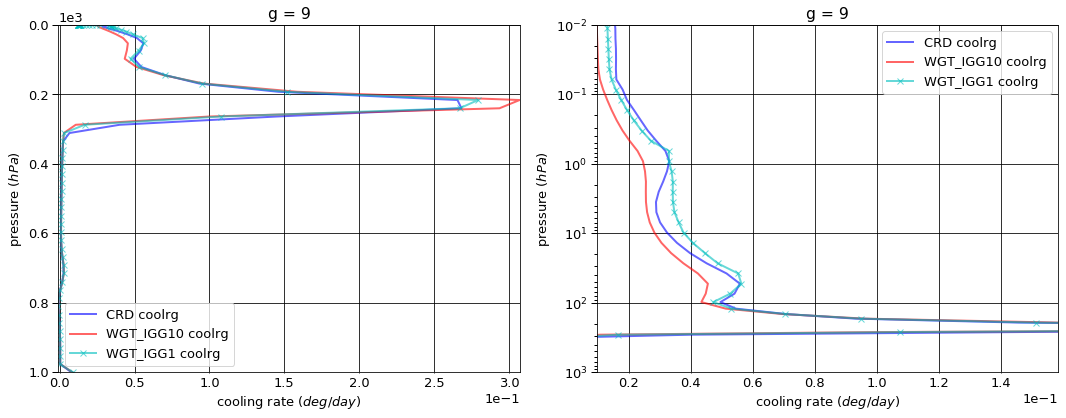

# Figure: cooling rate g-group 10

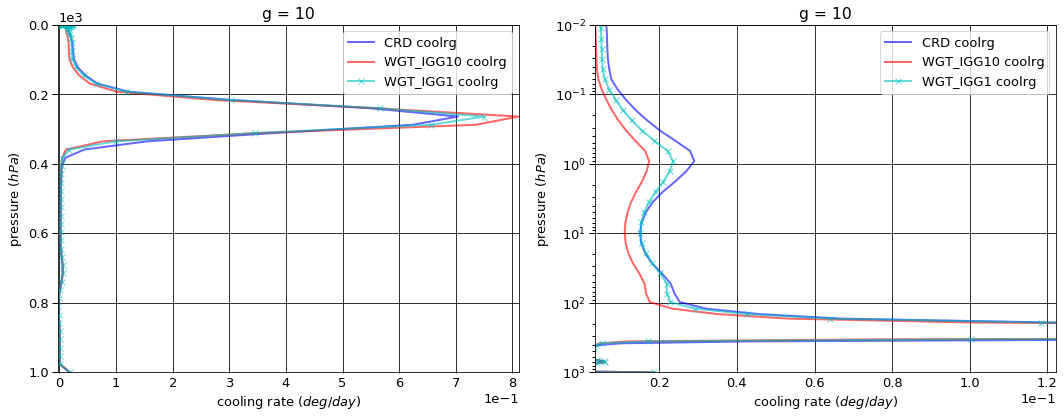

# Figure: cooling rate g-group 11

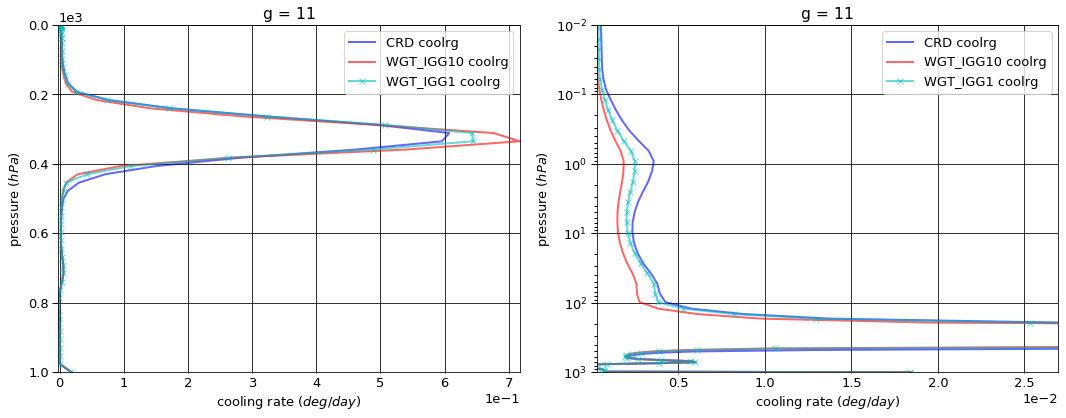

# Figure: cooling rate g-group 12

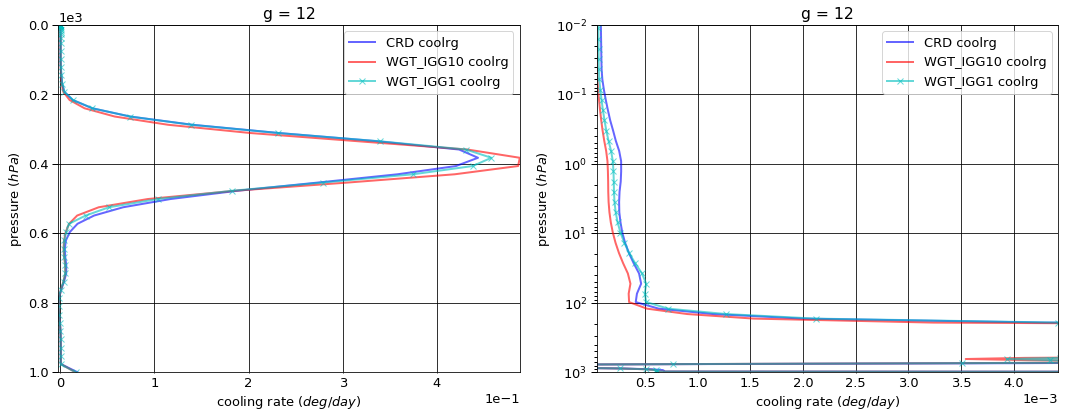

# Figure: cooling rate g-group total

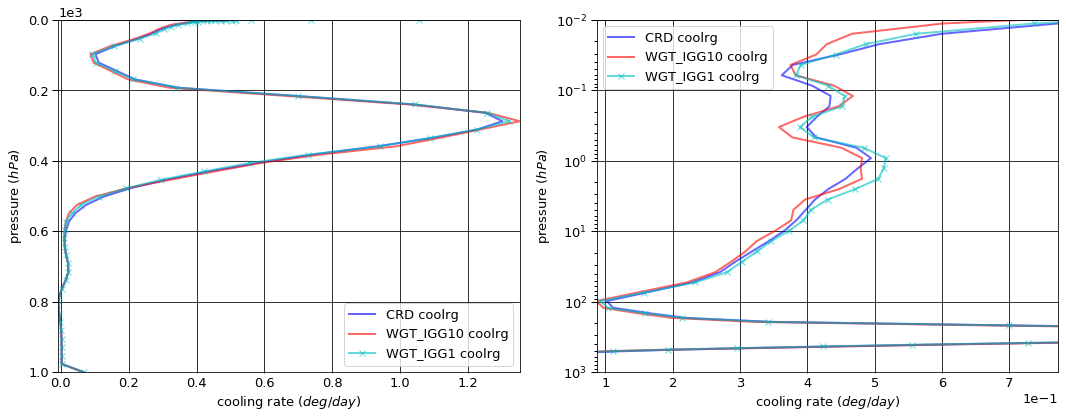

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg     fnetg
g  pressure level                                
1  0.0      1      -0.002859   0.000000 -0.002859
   1013.0   76     -0.005007   0.004991 -0.000016
2  0.0      1      -0.010955   0.000000 -0.010955
   1013.0   76     -0.018195   0.018126 -0.000069
3  0.0      1      -0.015743   0.000000 -0.015743
   1013.0   76     -0.020992   0.020920 -0.000072
4  0.0      1      -0.061693   0.000000 -0.061693
   1013.0   76     -0.077965   0.077719 -0.000247
5  0.0      1      -0.159399   0.000000 -0.159399
   1013.0   76     -0.227415   0.226643 -0.000772
6  0.0      1      -0.327952   0.000000 -0.327952
   1013.0   76     -0.513322   0.511623 -0.001699
7  0.0      1      -0.541192   0.000000 -0.541192
   1013.0   76     -0.944898   0.941762 -0.003137
8  0.0      1      -1.509039   0.000000 -1.509039
   1013.0   76     -2.788100   2.778801 -0.009299
9  0.0      1      -3.812245   0.000000 -3.812245
   1013.0   76     -6.530947   6.509203 -0.021744
10 0.0      1      -9.064526   0.000000 -9.064526
   1013.0   76    -14.231418  14.183535 -0.047882
11 0.0      1      -9.664253   0.000000 -9.664253
   1013.0   76    -14.370955  14.319688 -0.051267
12 0.0      1      -9.196900   0.000000 -9.196900
   1013.0   76    -13.135169  13.084085 -0.051084


WGT_IGG10


flug       fldg     fnetg
g  pressure level                                
1  0.0      1      -0.002744   0.000000 -0.002744
   1013.0   76     -0.005202   0.005183 -0.000018
2  0.0      1      -0.011036   0.000000 -0.011036
   1013.0   76     -0.017775   0.017712 -0.000063
3  0.0      1      -0.016010   0.000000 -0.016010
   1013.0   76     -0.021239   0.021164 -0.000075
4  0.0      1      -0.063200   0.000000 -0.063200
   1013.0   76     -0.080853   0.080567 -0.000286
5  0.0      1      -0.160822   0.000000 -0.160822
   1013.0   76     -0.230756   0.229939 -0.000818
6  0.0      1      -0.325653   0.000000 -0.325653
   1013.0   76     -0.525193   0.523333 -0.001861
7  0.0      1      -0.534800   0.000000 -0.534800
   1013.0   76     -0.965704   0.962283 -0.003421
8  0.0      1      -1.440788   0.000000 -1.440788
   1013.0   76     -2.845633   2.835552 -0.010081
9  0.0      1      -3.719901   0.000000 -3.719901
   1013.0   76     -6.669063   6.645436 -0.023627
10 0.0      1      -8.998363   0.000000 -8.998363
   1013.0   76    -14.481079  14.429775 -0.051303
11 0.0      1      -9.676552   0.000000 -9.676552
   1013.0   76    -14.335151  14.284364 -0.050786
12 0.0      1      -9.221954   0.000000 -9.221954
   1013.0   76    -12.686736  12.641789 -0.044946


WGT_IGG1


flug       fldg     fnetg
g  pressure level                                
1  0.0      1      -0.002746   0.000000 -0.002746
   1013.0   76     -0.005202   0.005183 -0.000018
2  0.0      1      -0.011080   0.000000 -0.011080
   1013.0   76     -0.017775   0.017712 -0.000063
3  0.0      1      -0.015951   0.000000 -0.015951
   1013.0   76     -0.021239   0.021164 -0.000075
4  0.0      1      -0.062977   0.000000 -0.062977
   1013.0   76     -0.080853   0.080567 -0.000286
5  0.0      1      -0.160669   0.000000 -0.160669
   1013.0   76     -0.230756   0.229939 -0.000818
6  0.0      1      -0.325430   0.000000 -0.325430
   1013.0   76     -0.525193   0.523333 -0.001861
7  0.0      1      -0.534251   0.000000 -0.534251
   1013.0   76     -0.965704   0.962283 -0.003421
8  0.0      1      -1.455638   0.000000 -1.455638
   1013.0   76     -2.845633   2.835552 -0.010081
9  0.0      1      -3.704044   0.000000 -3.704044
   1013.0   76     -6.669063   6.645436 -0.023627
10 0.0      1      -8.945336   0.000000 -8.945336
   1013.0   76    -14.481079  14.429775 -0.051303
11 0.0      1      -9.632603   0.000000 -9.632603
   1013.0   76    -14.335151  14.284364 -0.050786
12 0.0      1      -9.183795   0.000000 -9.183795
   1013.0   76    -12.686736  12.641789 -0.044946


WGT_IGG10 - CRD


flug      fldg     fnetg
g  pressure level                              
1  0.0      1      0.000115  0.000000  0.000115
   1013.0   76    -0.000195  0.000192 -0.000003
2  0.0      1     -0.000080  0.000000 -0.000080
   1013.0   76     0.000421 -0.000415  0.000006
3  0.0      1     -0.000267  0.000000 -0.000267
   1013.0   76    -0.000247  0.000244 -0.000003
4  0.0      1     -0.001506  0.000000 -0.001506
   1013.0   76    -0.002888  0.002848 -0.000039
5  0.0      1     -0.001423  0.000000 -0.001423
   1013.0   76    -0.003342  0.003296 -0.000046
6  0.0      1      0.002299  0.000000  0.002299
   1013.0   76    -0.011871  0.011709 -0.000162
7  0.0      1      0.006392  0.000000  0.006392
   1013.0   76    -0.020806  0.020521 -0.000285
8  0.0      1      0.068251  0.000000  0.068251
   1013.0   76    -0.057534  0.056751 -0.000783
9  0.0      1      0.092344  0.000000  0.092344
   1013.0   76    -0.138116  0.136233 -0.001883
10 0.0      1      0.066163  0.000000  0.066163
   1013.0   76    -0.249661  0.246240 -0.003421
11 0.0      1     -0.012299  0.000000 -0.012299
   1013.0   76     0.035804 -0.035324  0.000481
12 0.0      1     -0.025054  0.000000 -0.025054
   1013.0   76     0.448433 -0.442296  0.006138


WGT_IGG1 - CRD


flug      fldg     fnetg
g  pressure level                              
1  0.0      1      0.000113  0.000000  0.000113
   1013.0   76    -0.000195  0.000192 -0.000003
2  0.0      1     -0.000125  0.000000 -0.000125
   1013.0   76     0.000421 -0.000415  0.000006
3  0.0      1     -0.000208  0.000000 -0.000208
   1013.0   76    -0.000247  0.000244 -0.000003
4  0.0      1     -0.001284  0.000000 -0.001284
   1013.0   76    -0.002888  0.002848 -0.000039
5  0.0      1     -0.001270  0.000000 -0.001270
   1013.0   76    -0.003342  0.003296 -0.000046
6  0.0      1      0.002522  0.000000  0.002522
   1013.0   76    -0.011871  0.011709 -0.000162
7  0.0      1      0.006941  0.000000  0.006941
   1013.0   76    -0.020806  0.020521 -0.000285
8  0.0      1      0.053401  0.000000  0.053401
   1013.0   76    -0.057534  0.056751 -0.000783
9  0.0      1      0.108201  0.000000  0.108201
   1013.0   76    -0.138116  0.136233 -0.001883
10 0.0      1      0.119190  0.000000  0.119190
   1013.0   76    -0.249661  0.246240 -0.003421
11 0.0      1      0.031650  0.000000  0.031650
   1013.0   76     0.035804 -0.035324  0.000481
12 0.0      1      0.013105  0.000000  0.013105
   1013.0   76     0.448433 -0.442296  0.006138

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer          
1  0.000312    1      9.310840
   1001.112500 75     0.000006
2  0.000312    1      0.422934
   1001.112500 75     0.000025
3  0.000312    1      0.067373
   1001.112500 75     0.000026
4  0.000312    1      0.000042
   1001.112500 75     0.000089
5  0.000312    1      0.000826
   1001.112500 75     0.000279
6  0.000312    1      0.000042
   1001.112500 75     0.000615
7  0.000312    1      0.000578
   1001.112500 75     0.001135
8  0.000312    1      0.000163
   1001.112500 75     0.003363
9  0.000312    1      0.013113
   1001.112500 75     0.007865
10 0.000312    1      0.005170
   1001.112500 75     0.017319
11 0.000312    1      0.000407
   1001.112500 75     0.018537
12 0.000312    1      0.000069
   1001.112500 75     0.018463


WGT_IGG10


coolrg
g  pressure    layer          
1  0.000312    1      7.049062
   1001.112500 75     0.000007
2  0.000312    1      0.303439
   1001.112500 75     0.000023
3  0.000312    1      0.032622
   1001.112500 75     0.000027
4  0.000312    1      0.000029
   1001.112500 75     0.000104
5  0.000312    1      0.000577
   1001.112500 75     0.000296
6  0.000312    1      0.000038
   1001.112500 75     0.000673
7  0.000312    1      0.000469
   1001.112500 75     0.001237
8  0.000312    1      0.000130
   1001.112500 75     0.003645
9  0.000312    1      0.008784
   1001.112500 75     0.008543
10 0.000312    1      0.002930
   1001.112500 75     0.018551
11 0.000312    1      0.000213
   1001.112500 75     0.018364
12 0.000312    1      0.000035
   1001.112500 75     0.016252


WGT_IGG1


coolrg
g  pressure    layer          
1  0.000312    1      7.604981
   1001.112500 75     0.000007
2  0.000312    1      0.356549
   1001.112500 75     0.000023
3  0.000312    1      0.043587
   1001.112500 75     0.000027
4  0.000312    1      0.000036
   1001.112500 75     0.000104
5  0.000312    1      0.000653
   1001.112500 75     0.000296
6  0.000312    1      0.000044
   1001.112500 75     0.000673
7  0.000312    1      0.000538
   1001.112500 75     0.001237
8  0.000312    1      0.000150
   1001.112500 75     0.003645
9  0.000312    1      0.011913
   1001.112500 75     0.008543
10 0.000312    1      0.004090
   1001.112500 75     0.018551
11 0.000312    1      0.000299
   1001.112500 75     0.018364
12 0.000312    1      0.000049
   1001.112500 75     0.016252


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -2.261778e+00
   1001.112500 75     9.598827e-07
2  0.000312    1     -1.194957e-01
   1001.112500 75    -2.087475e-06
3  0.000312    1     -3.475151e-02
   1001.112500 75     1.183131e-06
4  0.000312    1     -1.302674e-05
   1001.112500 75     1.421840e-05
5  0.000312    1     -2.487392e-04
   1001.112500 75     1.648262e-05
6  0.000312    1     -3.325412e-06
   1001.112500 75     5.827673e-05
7  0.000312    1     -1.091925e-04
   1001.112500 75     1.025384e-04
8  0.000312    1     -3.333402e-05
   1001.112500 75     2.820236e-04
9  0.000312    1     -4.329438e-03
   1001.112500 75     6.782571e-04
10 0.000312    1     -2.240187e-03
   1001.112500 75     1.231852e-03
11 0.000312    1     -1.934052e-04
   1001.112500 75    -1.734240e-04
12 0.000312    1     -3.440107e-05
   1001.112500 75    -2.210364e-03


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -1.705859e+00
   1001.112500 75     9.598827e-07
2  0.000312    1     -6.638574e-02
   1001.112500 75    -2.087475e-06
3  0.000312    1     -2.378649e-02
   1001.112500 75     1.183131e-06
4  0.000312    1     -6.923416e-06
   1001.112500 75     1.421840e-05
5  0.000312    1     -1.730243e-04
   1001.112500 75     1.648262e-05
6  0.000312    1      1.952206e-06
   1001.112500 75     5.827673e-05
7  0.000312    1     -4.050916e-05
   1001.112500 75     1.025384e-04
8  0.000312    1     -1.257605e-05
   1001.112500 75     2.820236e-04
9  0.000312    1     -1.200562e-03
   1001.112500 75     6.782571e-04
10 0.000312    1     -1.079859e-03
   1001.112500 75     1.231852e-03
11 0.000312    1     -1.078684e-04
   1001.112500 75    -1.734240e-04
12 0.000312    1     -2.008503e-05
   1001.112500 75    -2.210364e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-34.366756,0.000000,-34.366756
1013.0,76,-52.864384,52.677096,-0.187287



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-34.171822,0.000000,-34.171822
1013.0,76,-52.864385,52.677096,-0.187287



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-34.034518,0.000000,-34.034518
1013.0,76,-52.864385,52.677096,-0.187287



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.194935,0.000000e+00,1.949345e-01
1013.0,76,-0.000001,-1.095000e-07,1.824690e-07



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.332238,0.000000e+00,3.322380e-01
1013.0,76,-0.000001,-1.095000e-07,1.824690e-07


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,9.821558
1001.112500,75,0.067721



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,7.398328
1001.112500,75,0.067721



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,8.022888
1001.112500,75,0.067721



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-2.423230e+00
1001.112500,75,-8.361330e-08



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-1.798670e+00
1001.112500,75,-8.361330e-08


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000125,0.000098
2,0.000250,0.000336
3,0.000500,0.000402
4,0.001875,0.001529
5,0.004750,0.004365
6,0.012188,0.009935
7,0.020625,0.018268
8,0.064562,0.053829
9,0.150812,0.126154


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,3.428976e-16
2,5.434972e-17
3,8.614503e-18
4,1.160099e-17
5,2.152872e-18
6,3.995224e-19
7,6.708836e-19
8,1.270181e-19
9,2.404829e-20


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,3.428976e-16,NaN,0.000125,0.000098,0.000125,0.000098,1.0
2,5.434972e-17,0.158501,0.000250,0.000336,0.000375,0.000435,1.0
3,8.614503e-18,0.158501,0.000500,0.000402,0.000875,0.000836,1.0
4,1.160099e-17,1.346682,0.001875,0.001529,0.002750,0.002366,30.0
5,2.152872e-18,0.185577,0.004750,0.004365,0.007500,0.006731,30.0
6,3.995224e-19,0.185577,0.012188,0.009935,0.019688,0.016666,30.0
7,6.708836e-19,1.679214,0.020625,0.018268,0.040313,0.034933,300.0
8,1.270181e-19,0.189330,0.064562,0.053829,0.104875,0.088762,300.0
9,2.404829e-20,0.189330,0.150812,0.126154,0.255687,0.214916,300.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
